In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
import os

# Correcting the typo from os.path.json to os.path.join
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [7]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [ ]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("fuel-price-experiment")

<Experiment: artifact_location='file:///c:/BITrusted/fuel-price-prediction/src/mlruns/2', creation_time=1722000115878, experiment_id='2', last_update_time=1722000115878, lifecycle_stage='active', name='fuel-price-experiment', tags={}>

In [ ]:
data_path = '../data/2024_globus_gas_prices.parquet'
df = pd.read_parquet(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3285 non-null   object 
 1   station_uuid  3285 non-null   object 
 2   diesel        3285 non-null   float64
 3   e5            3285 non-null   float64
 4   e10           3285 non-null   float64
 5   dieselchange  3285 non-null   int64  
 6   e5change      3285 non-null   int64  
 7   e10change     3285 non-null   int64  
 8   source        3285 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 231.1+ KB


In [ ]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3285 entries, 2023-12-31 23:57:17+00:00 to 2024-07-21 21:07:01+00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_uuid  3285 non-null   object 
 1   diesel        3285 non-null   float64
 2   e5            3285 non-null   float64
 3   e10           3285 non-null   float64
 4   dieselchange  3285 non-null   int64  
 5   e5change      3285 non-null   int64  
 6   e10change     3285 non-null   int64  
 7   source        3285 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 231.0+ KB


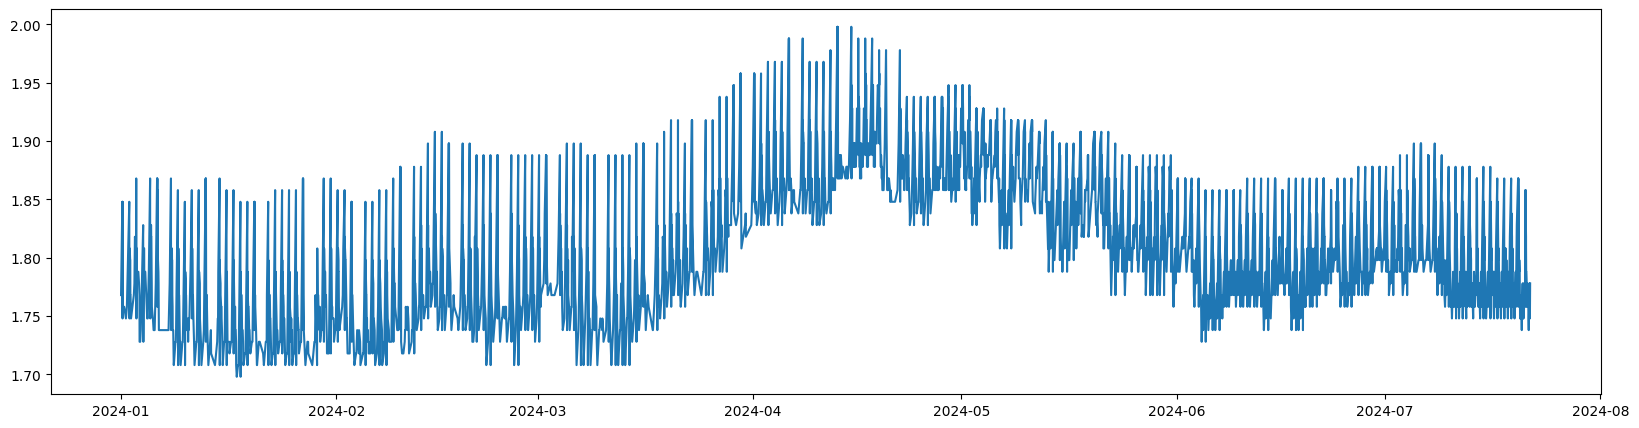

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(df['e5'])

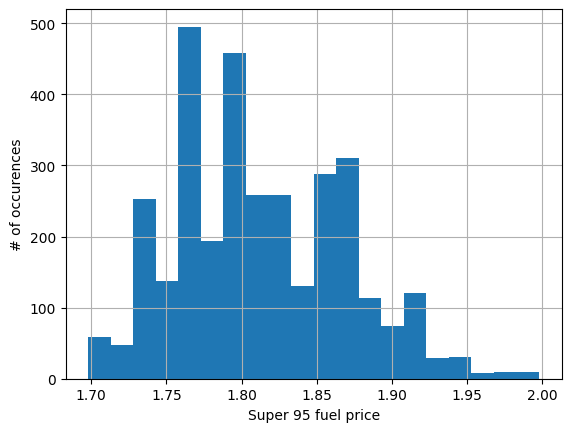

In [ ]:
df['e5'].hist(bins = 20)
plt.xlabel('Super 95 fuel price')
plt.ylabel('# of occurences')
plt.show()

Test Statistic            -1.624844
p-value                    0.470191
Lags Used                 28.000000
Observations Used       3256.000000
Critical Value (1%)       -3.432360
Critical Value (5%)       -2.862428
Critical Value (10%)      -2.567243
dtype: float64


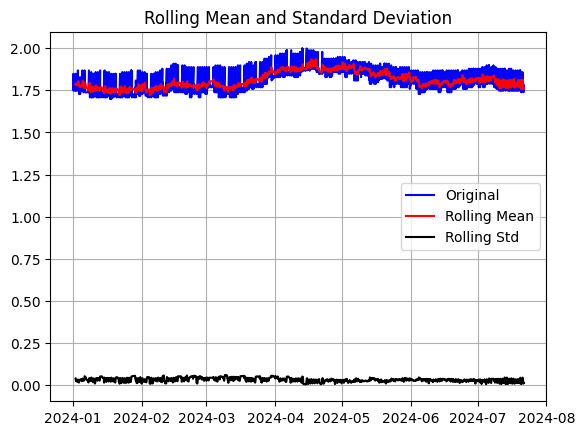

In [ ]:
df_e5 = df['e5']
dftest(df_e5)

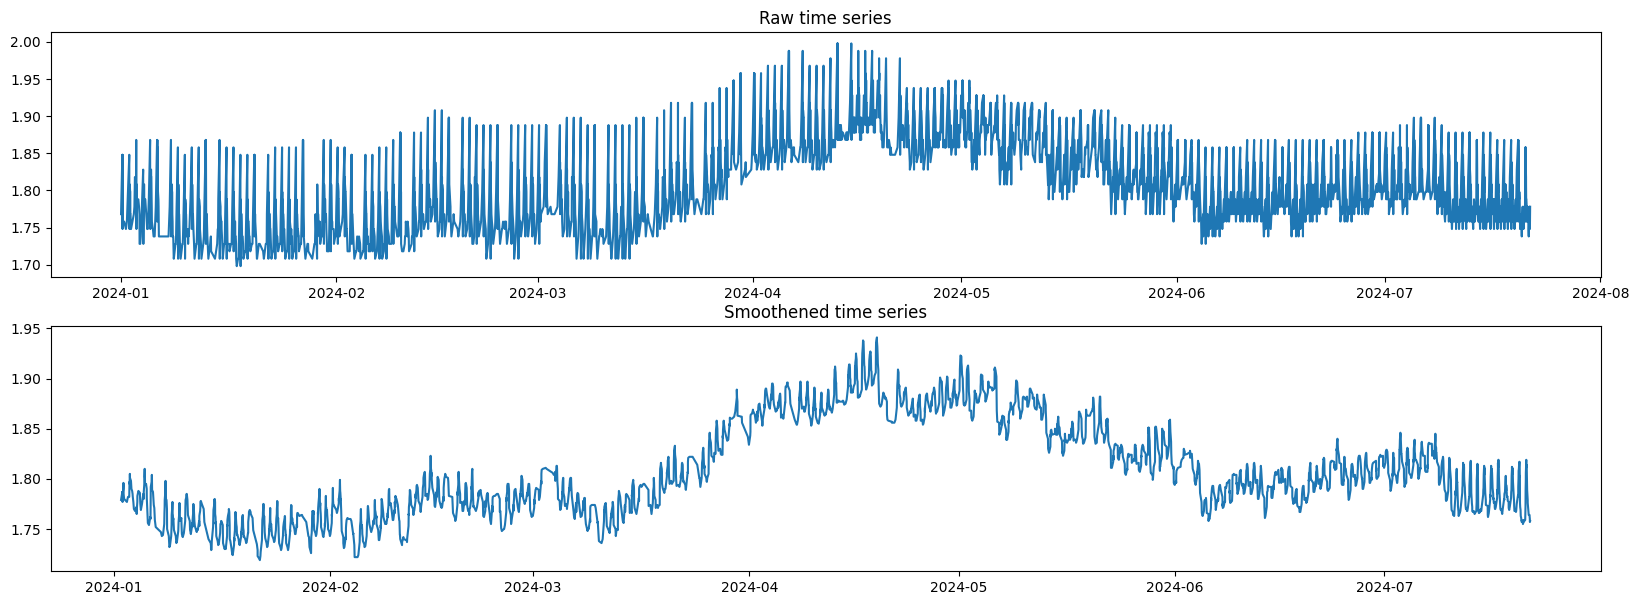

In [ ]:
smooth_df_e5 = df_e5.rolling(window= 10).mean()
fig, ax = plt.subplots(2,1,figsize = (20,7))
ax[0].plot(df_e5)
ax[0].set_title('Raw time series')
ax[1].plot(smooth_df_e5)
ax[1].set_title('Smoothened time series')
plt.show()

In [ ]:
type(df_e5)

pandas.core.series.Series

In [ ]:
df_e5 = pd.DataFrame(df_e5)
type(df_e5)

pandas.core.frame.DataFrame

In [ ]:
df_e5.head()

,e5
date,
2023-12-31 23:57:17+00:00,1.768
2024-01-01 04:23:50+00:00,1.848
2024-01-01 05:07:27+00:00,1.748
2024-01-01 05:11:31+00:00,1.848
2024-01-01 05:35:53+00:00,1.758


In [ ]:
from collections import Counter

# Your existing timestamps
timestamps = df_e5.index

# Calculate time differences
time_diffs = timestamps[1:] - timestamps[:-1]

# Convert to minutes for easier analysis
time_diffs_minutes = time_diffs.total_seconds() / 60

# Analyze the differences
mean_diff = np.mean(time_diffs_minutes)
median_diff = np.median(time_diffs_minutes)
mode_diff = Counter(time_diffs_minutes.round()).most_common(1)[0][0]

print(f"Mean difference: {mean_diff:.2f} minutes")
print(f"Median difference: {median_diff:.2f} minutes")
print(f"Mode difference: {mode_diff:.2f} minutes")

Mean difference: 88.96 minutes
Median difference: 44.50 minutes
Mode difference: 12.00 minutes


In [ ]:
sampling_freq = '1h'
df_e5_resampled = df_e5.resample(sampling_freq).mean().interpolate(method = "linear")
df_e5_resampled.head()

,e5
date,
2023-12-31 23:00:00+00:00,1.768
2024-01-01 00:00:00+00:00,1.784
2024-01-01 01:00:00+00:00,1.800
2024-01-01 02:00:00+00:00,1.816
2024-01-01 03:00:00+00:00,1.832


<Axes: xlabel='date'>

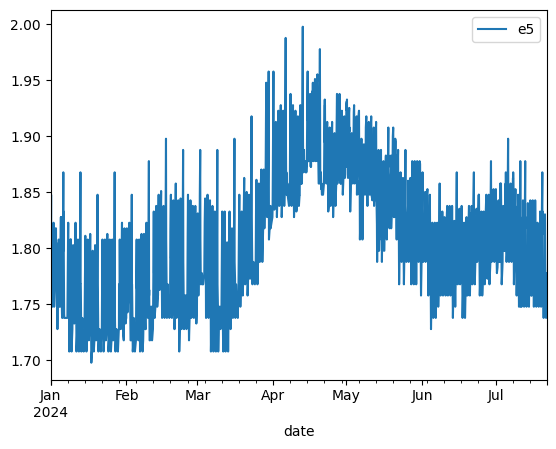

In [ ]:
df_e5_resampled.plot()

#### Split data into Train, Validation, Test 

Training data: 01.01.2024 - 31.05.2024

Vaidation data: 01.06.2024 - 13.07.2024

Test data: 14.07.2024 - 21.07.2024


In [ ]:
data = df_e5_resampled

In [ ]:
train_data = data[:'2024-05-31']
train_data.tail()

,e5
date,
2024-05-31 19:00:00+00:00,1.793000
2024-05-31 20:00:00+00:00,1.801333
2024-05-31 21:00:00+00:00,1.809667
2024-05-31 22:00:00+00:00,1.818000
2024-05-31 23:00:00+00:00,1.828000


In [ ]:
val_data = data['2024-06-01':'2024-07-13']
val_data.tail()

,e5
date,
2024-07-13 19:00:00+00:00,1.771333
2024-07-13 20:00:00+00:00,1.769667
2024-07-13 21:00:00+00:00,1.768000
2024-07-13 22:00:00+00:00,1.758000
2024-07-13 23:00:00+00:00,1.764000


In [ ]:
test_data = data['2024-07-14':]
test_data.tail()

,e5
date,
2024-07-21 17:00:00+00:00,1.748
2024-07-21 18:00:00+00:00,1.758
2024-07-21 19:00:00+00:00,1.768
2024-07-21 20:00:00+00:00,1.748
2024-07-21 21:00:00+00:00,1.778


In [ ]:
print(train_data.shape, val_data.shape, test_data.shape)

(3649, 1) (1032, 1) (190, 1)


### Prepare training and validation dataset

#### Training data

In [ ]:
dataset_train = train_data.values
dataset_train = dataset_train[~np.isnan(dataset_train)]
# reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape

(3649, 1)

#### Validation data

In [ ]:
dataset_val = val_data.values
dataset_val = dataset_val[~np.isnan(dataset_val)]
# reshaping 1D to 2D array
dataset_val = np.reshape(dataset_val, (-1, 1))
dataset_val.shape

(1032, 1)

#### Test data

In [ ]:
dataset_test = test_data.values
dataset_test = dataset_test[~np.isnan(dataset_test)]
# reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(190, 1)

### Transforming data into Sequence

In [ ]:
import torch

# Create sequences and labels for training data
sequence_length = 48 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(dataset_train) - sequence_length):
	X_train.append(dataset_train[i:i+sequence_length])
	y_train.append(dataset_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([3601, 48, 1]), torch.Size([3601, 48, 1]))

#### Validation Data

In [ ]:
# Create sequences and labels for training data
sequence_length = 24 # Number of time steps to look back
X_val, y_val = [], []
for i in range(len(dataset_val) - sequence_length):
	X_val.append(dataset_val[i:i+sequence_length])
	y_val.append(dataset_val[i+1:i+sequence_length+1])
X_val, y_val = np.array(X_val), np.array(y_val)

# Convert data to PyTorch tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_val.shape,y_val.shape

(torch.Size([1008, 24, 1]), torch.Size([1008, 24, 1]))

### Define LSTM class model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

#### Check hardware availability

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Define model

In [ ]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


#### Create Data Loader for Batch Training

In [ ]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#### Model Training & Evaluations

In [ ]:
num_epochs = 50

# Start MLflow run
mlflow.start_run()

mlflow.set_tag("developer", "Victor")

# log data
mlflow.log_param("data_path", data_path)

# log parameters
mlflow.log_param("input_size", input_size)
mlflow.log_param("num_layers", num_layers)
mlflow.log_param("hidden_size", hidden_size)
mlflow.log_param("output_size", output_size)
mlflow.log_param("num_epochs", num_epochs)
mlflow.log_param("learning_rate", learning_rate)


train_hist =[]
val_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_train_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_train_loss += loss.item()
	
	
	# Calculate average training loss and accuracy
	average_train_loss = total_train_loss / len(train_loader)
	train_hist.append(average_train_loss)

	# log training loss
	mlflow.log_metric("avg_train_loss", average_train_loss, step = epoch)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_val_loss = 0.0

		for batch_X_val, batch_y_val in val_loader:
			batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
			predictions_val = model(batch_X_val)
			val_loss = loss_fn(predictions_val, batch_y_val)

			total_val_loss += val_loss.item()

		# Calculate average test loss and accuracy
		average_val_loss = total_val_loss / len(val_loader)
		val_hist.append(average_val_loss)

	# log validation loss
	mlflow.log_metric("avg_val_loss", average_val_loss, step = epoch)


	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

# Log model
mlflow.pytorch.log_model(model, "LSTM-model")

# End MLflow run
mlflow.end_run()


Epoch [10/50] - Training Loss: 0.0006, Val Loss: 0.0010
Epoch [20/50] - Training Loss: 0.0002, Val Loss: 0.0002
Epoch [30/50] - Training Loss: 0.0002, Val Loss: 0.0002
Epoch [40/50] - Training Loss: 0.0002, Val Loss: 0.0002
Epoch [50/50] - Training Loss: 0.0002, Val Loss: 0.0002


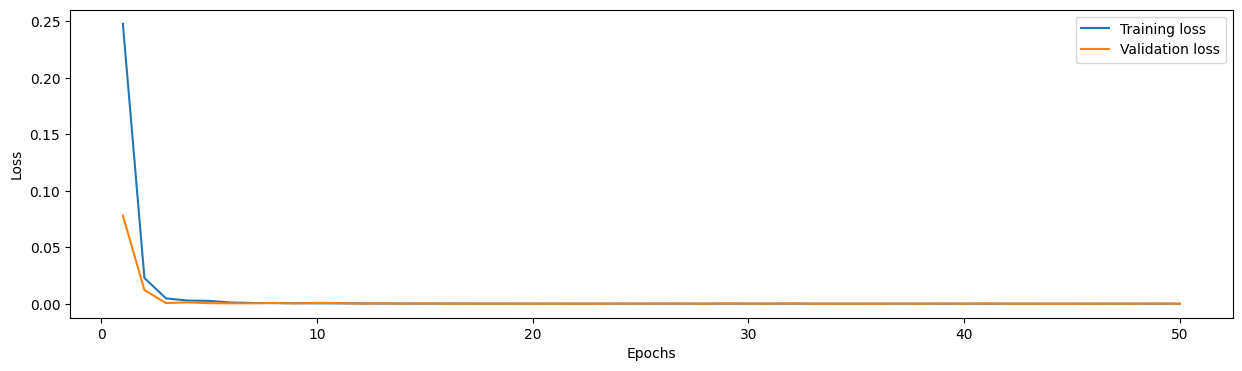

In [ ]:
fig, ax = plt.subplots(figsize= (15,4))
x = np.linspace(1,num_epochs,num_epochs)
ax.plot(x, train_hist,scalex=True, label="Training loss")
ax.plot(x, val_hist, label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Forecasting

In [ ]:
# Choose a method to generate future timestamps (using median in this example)
def generate_future_timestamps(start_time, num_predictions, interval_minutes):
    future_times = pd.date_range(start=start_time, periods=num_predictions+1, freq=f'{interval_minutes}T')[1:]
    return future_times

# Generate future timestamps
last_timestamp = val_data.index[-1]
num_predictions = 10  # Number of future predictions you want
time_interval_min = 15 # minutes
future_timestamps = generate_future_timestamps(last_timestamp, num_predictions, time_interval_min)

print("\nFuture Timestamps:")
for ts in future_timestamps:
    print(ts)


Future Timestamps:
2024-07-13 23:15:00+00:00
2024-07-13 23:30:00+00:00
2024-07-13 23:45:00+00:00
2024-07-14 00:00:00+00:00
2024-07-14 00:15:00+00:00
2024-07-14 00:30:00+00:00
2024-07-14 00:45:00+00:00
2024-07-14 01:00:00+00:00
2024-07-14 01:15:00+00:00
2024-07-14 01:30:00+00:00


In [ ]:
# Define the number of future time steps to forecast
num_forecast_steps = 48 # next timesteps to forecast
time_interval_min = 60 # @minute intervals

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_val.squeeze().cpu().numpy()

# Use the last 24 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

prediction_horizon = num_forecast_steps + len(historical_data)
# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(prediction_horizon):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
		

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value


		
# Generate futute dates
last_timestamp = val_data.index[-1]

# Generate the next stipulated timepoints
#future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=1)
future_timestamps = generate_future_timestamps(last_timestamp, num_forecast_steps, time_interval_min)

# Concatenate the original index with the future dates
#combined_index = val_data.index.append(future_dates)
combined_index = val_data.index.append(future_timestamps)


(24,)


C:\Users\emenike\AppData\Local\Temp\ipykernel_2184\3838030538.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


In [ ]:
print(f'Predicted value: {predicted_value}')

Predicted value: [1.7630274]


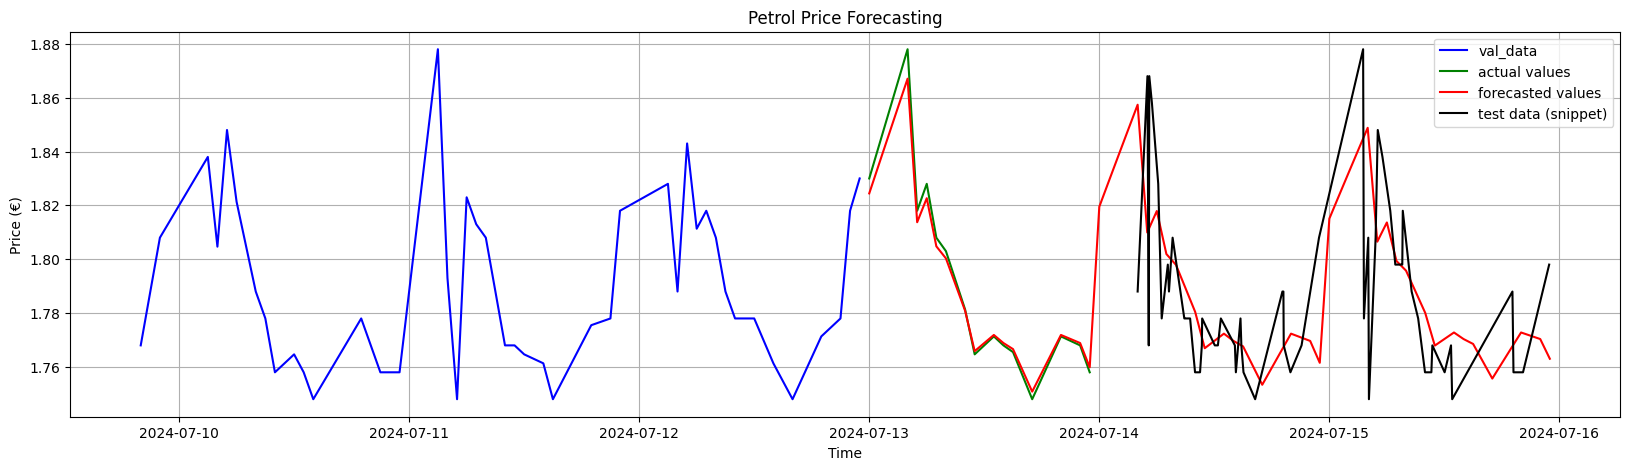

In [ ]:
#set the size of the plot 
fig, ax = plt.subplots(figsize = (20,5))


#Test data
ax.plot(val_data.index[-100:-24], val_data[-100:-24], label = "val_data", color = "b") 
#reverse the scaling transformation
original_cases = np.expand_dims(sequence_to_plot[-1], axis=0).flatten() 

#the historical data used as input for forecasting
ax.plot(val_data.index[-24:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = np.expand_dims(forecasted_values, axis=0).flatten() 
# plotting the forecasted values
ax.plot(combined_index[-prediction_horizon:], forecasted_cases, label='forecasted values', color='red') 

ds = df_e5.index
test_timestamps = ds[(ds >= future_timestamps[0]) & (ds <= future_timestamps[-1])]

ax.plot(test_timestamps, 
         df_e5[future_timestamps[0]: future_timestamps[-1]], label='test data (snippet)', color='black') 

plt.xlabel('Time')
plt.ylabel('Price (€)')
plt.legend()
plt.title('Petrol Price Forecasting')
plt.grid(True)


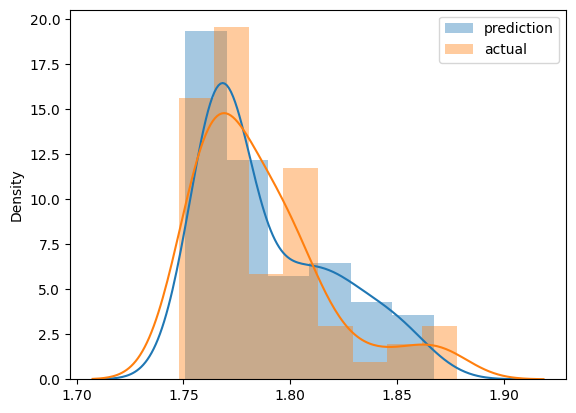

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
sns.distplot(forecasted_cases, label = 'prediction')
sns.distplot(df_e5[future_timestamps[0]: future_timestamps[-1]], label = 'actual')
plt.legend()
plt.show()

In [ ]:
test_timestamps

DatetimeIndex(['2024-07-14 03:59:59+00:00', '2024-07-14 05:01:21+00:00',
               '2024-07-14 05:09:35+00:00', '2024-07-14 05:12:59+00:00',
               '2024-07-14 05:29:24+00:00', '2024-07-14 06:08:53+00:00',
               '2024-07-14 06:30:36+00:00', '2024-07-14 07:08:54+00:00',
               '2024-07-14 07:16:06+00:00', '2024-07-14 07:38:54+00:00',
               '2024-07-14 08:52:08+00:00', '2024-07-14 08:55:17+00:00',
               '2024-07-14 09:28:26+00:00', '2024-07-14 09:43:42+00:00',
               '2024-07-14 09:59:19+00:00', '2024-07-14 10:10:41+00:00',
               '2024-07-14 10:18:54+00:00', '2024-07-14 10:30:33+00:00',
               '2024-07-14 10:41:53+00:00', '2024-07-14 10:43:54+00:00',
               '2024-07-14 12:02:59+00:00', '2024-07-14 12:22:22+00:00',
               '2024-07-14 12:40:47+00:00', '2024-07-14 14:08:43+00:00',
               '2024-07-14 14:14:52+00:00', '2024-07-14 14:43:50+00:00',
               '2024-07-14 14:49:13+00:00', '2024-0

#### Inference with MLflow

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
logged_model = 'runs:/f24c78650a074e1aa5b737d86fe784ca/LSTM-model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Define the number of future time steps to forecast
num_forecast_steps = 48 # next timesteps to forecast
time_interval_min = 60 # @minute intervals

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_val.squeeze().cpu().numpy()

# Use the last 24 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

prediction_horizon = num_forecast_steps + len(historical_data)
# Use the trained model to forecast future values

for _ in range(prediction_horizon):
	# Prepare the historical_data tensor
	
	# Use the model to predict the next value
	predicted_value = loaded_model.predict(pd.DataFrame(historical_data))
	#print(f'predicted values: {predicted_value.head()} of type {type(predicted_value)}')
	
	# Append the predicted value to the forecasted_values list
	forecasted_values.append(predicted_value.values[0][0])

	# Update the historical_data sequence by removing the oldest value and adding the predicted value
	historical_data = np.roll(historical_data, shift=-1)
	#print(f'Rolled historical data {historical_data} with length {len(historical_data)}')
	historical_data[-1] = predicted_value.values[0]
	#print(f'Updated historical data {historical_data}')

		
# Generate futute dates
last_timestamp = val_data.index[-1]

# Generate the next stipulated timepoints
future_timestamps = generate_future_timestamps(last_timestamp, num_forecast_steps, time_interval_min)

# Concatenate the original index with the future dates
combined_index = val_data.index.append(future_timestamps)

In [ ]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: LSTM-model
  flavor: mlflow.pytorch
  run_id: f24c78650a074e1aa5b737d86fe784ca

In [ ]:
pytorch_model = mlflow.pytorch.load_model(logged_model)
pytorch_model

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

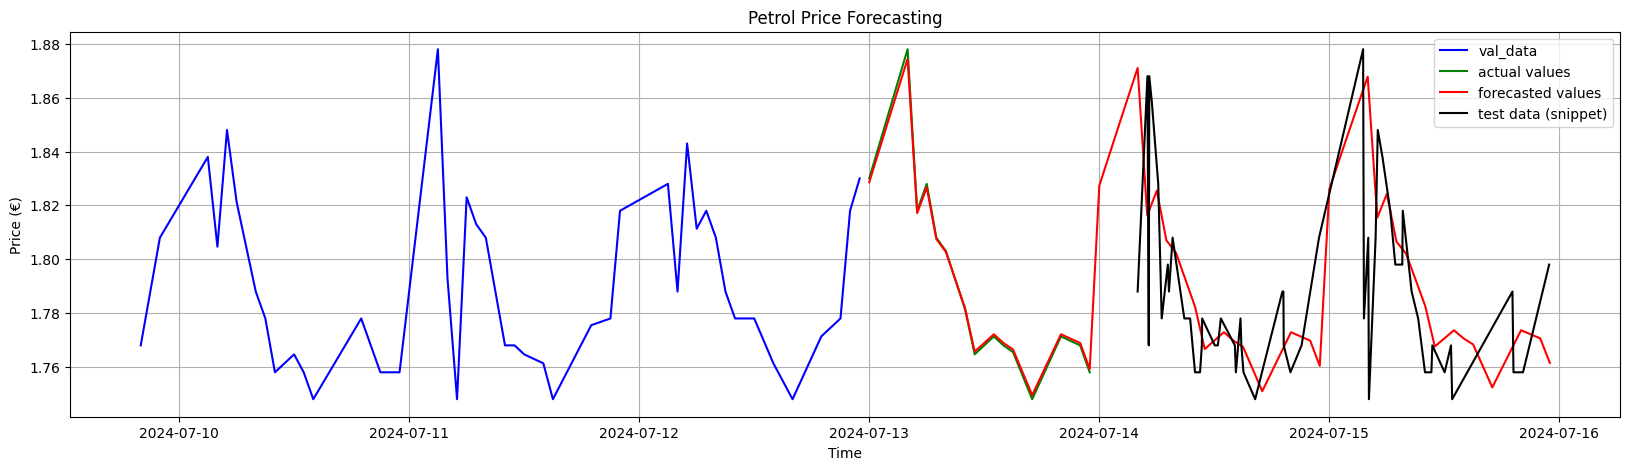

In [ ]:
#set the size of the plot 
fig, ax = plt.subplots(figsize = (20,5))


#Test data
ax.plot(val_data.index[-100:-24], val_data[-100:-24], label = "val_data", color = "b") 
#reverse the scaling transformation
original_cases = np.expand_dims(sequence_to_plot[-1], axis=0).flatten() 

#the historical data used as input for forecasting
ax.plot(val_data.index[-24:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = np.expand_dims(forecasted_values, axis=0).flatten() 
# plotting the forecasted values
ax.plot(combined_index[-prediction_horizon:], forecasted_cases, label='forecasted values', color='red') 

ds = df_e5.index
test_timestamps = ds[(ds >= future_timestamps[0]) & (ds <= future_timestamps[-1])]

ax.plot(test_timestamps, 
         df_e5[future_timestamps[0]: future_timestamps[-1]], label='test data (snippet)', color='black') 

plt.xlabel('Time')
plt.ylabel('Price (€)')
plt.legend()
plt.title('Petrol Price Forecasting')
plt.grid(True)